<a href="https://colab.research.google.com/github/OJB-Quantum/Ubermag-How-To/blob/main/NIST_Standard_Problem_4_with_Ubermag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# ----------------------------- Cell 1 -----------------------------
# Install the condacolab helper (adds a functional conda to Colab)
!pip -q install condacolab

# Import the helper and let it install Miniconda
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [13]:
# ----------------------------- Cell 2 -----------------------------
# After the restart you can now use the 'conda' command.
# Install Ubermag (and OOMMF) from the conda‑forge channel.
!conda install -c conda-forge ubermag -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



micromagneticmodel version: 0.65.0
--------------------------------------------------
Mesh: Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[5e-07, 1.25e-07, 3e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[100, 25, 1])
Applied field (A m⁻¹): (-19576.05800030313, 3421.8312764757497, 0.0)
System definition finished.
--------------------------------------------------
Starting the time driver …
Running OOMMF (ExeOOMMFRunner)[2025-11-06T15:45:34]... (4.0 s)
Finished – elapsed 4.05 s
--------------------------------------------------


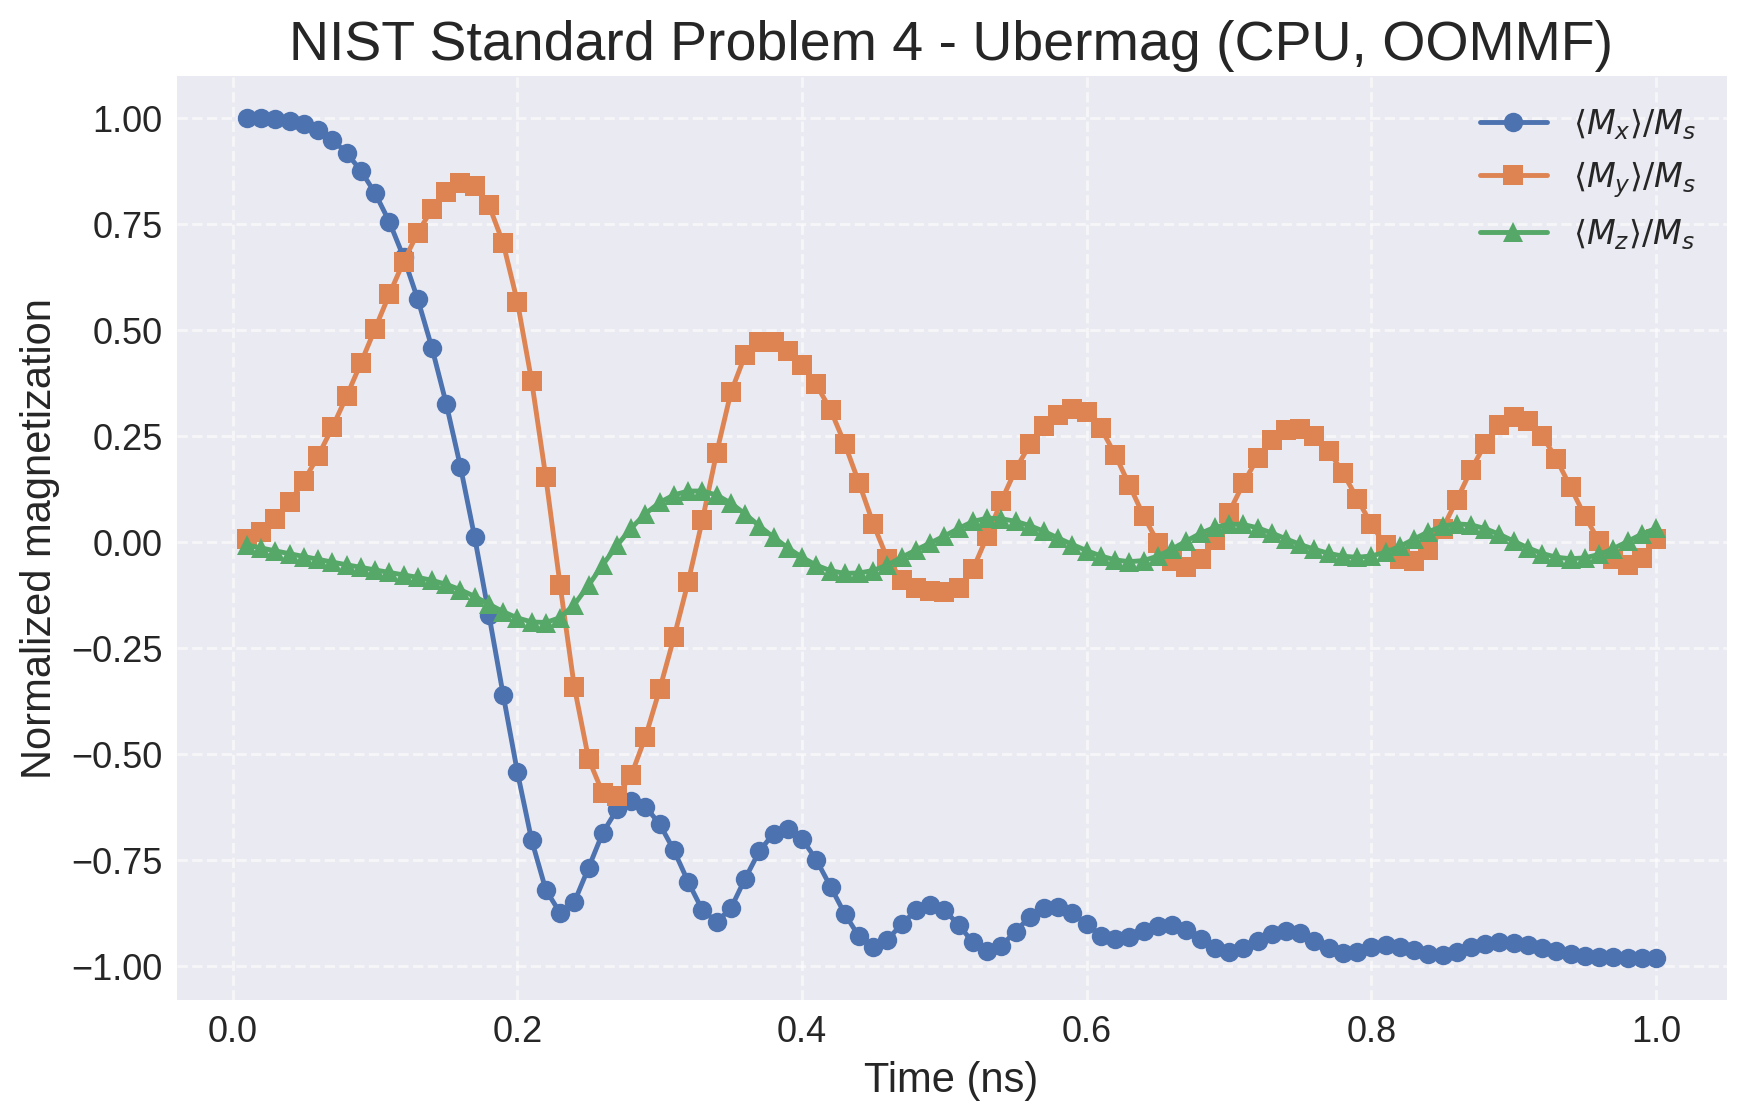

In [18]:
# -*- coding: utf-8 -*-
"""NIST Standard Problem 4 with Ubermag
"""

# ----------------------------- Cell 3 -----------------------------
#   Imports -------------------------------------------------
import micromagneticmodel as mm          # DSL for energy & dynamics
import discretisedfield    as df          # mesh & field handling
import oommfc               as oc          # OOMMF drivers (TimeDriver, MinDriver,…)
import numpy                as np
import matplotlib.pyplot    as plt
import time                                 # simple timing helper

plt.rcParams['figure.dpi'] = 200

print(f"micromagneticmodel version: {mm.__version__}")
print("-"*50)


#   Geometry, mesh and material -----------------------------
L, W, t = 500e-9, 125e-9, 3e-9                 # thin‑film dimensions (m)
cell    = (5e-9, 5e-9, 3e-9)                   # discretization (≤5 nm × 5 nm × 3 nm)

mesh = df.Mesh(p1=(0, 0, 0), p2=(L, W, t), cell=cell)
print(f"Mesh: {mesh}")

# Material parameters (Permalloy‑like)
Ms    = 8.0e5          # saturation magnetization (A m⁻¹)
A     = 1.3e-11        # exchange stiffness (J m⁻¹)
alpha = 0.02           # Gilbert damping
gamma0 = 2.211e5       # gyromagnetic ratio (m A⁻¹ s⁻¹)

# External field B = (‑24.6, 4.3, 0) mT → H = B / μ₀
mu_0 = 4*np.pi*1e-7
Hx   = -24.6e-3 / mu_0
Hy   =  4.3e-3 / mu_0
H_appl = (Hx, Hy, 0.0)                     # (A m⁻¹)

print(f"Applied field (A m⁻¹): {H_appl}")


#   Build the micromagnetic system -------------------------
system = mm.System(name="stdprob4")

# Energy: Exchange + Demag + Zeeman
system.energy = (
    mm.Exchange(A=A) +
    mm.Demag() +
    mm.Zeeman(H=H_appl)
)

# Dynamics: Precession + Damping (LLG)
system.dynamics = (
    mm.Precession(gamma0=gamma0) +
    mm.Damping(alpha=alpha)
)

# Initial magnetization – uniform +x, normalised to Ms.
# NOTE: the keyword is **nvdim**, not *dim* (the API changed in 2023)【43†L18-L23】.
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=Ms)

print("System definition finished.")
print("-"*50)


#   (Optional) Relax at zero field first --------------------
# The official NIST protocol first relaxes the sample with H = 0.
# Uncomment the two lines below if you want that step.
# relax = oc.MinDriver()
# relax.drive(system)


#   Time‑drive (1 ns, 100 snapshots) -----------------------
t_sim  = 1e-9      # total simulation time (s)
n_save = 100       # OOMMF will write 100 data points

driver = oc.TimeDriver()          # the same driver shown in the tutorial【37†L388-L390】
print("Starting the time driver …")
tic = time.time()
driver.drive(system, t=t_sim, n=n_save)
print(f"Finished – elapsed {time.time() - tic:.2f} s")
print("-"*50)


#   Post‑processing & plotting ----------------------------
# The driver automatically creates a Table object attached to the system.
# All columns are stored in a pandas DataFrame.
system.table.data['t_ns'] = system.table.data['t'] * 1e9   # ns for the x‑axis

plt.figure(figsize=(10, 6))
plt.plot(system.table.data['t_ns'], system.table.data['mx'],
         'o-', label=r'$\langle M_x\rangle/M_s$')
plt.plot(system.table.data['t_ns'], system.table.data['my'],
         's-', label=r'$\langle M_y\rangle/M_s$')
plt.plot(system.table.data['t_ns'], system.table.data['mz'],
         '^-', label=r'$\langle M_z\rangle/M_s$')
plt.title("NIST Standard Problem 4 - Ubermag (CPU, OOMMF)")
plt.xlabel("Time (ns)")
plt.ylabel("Normalized magnetization")
plt.grid(True, ls='--', alpha=0.6)
plt.legend()
plt.show()


In [19]:
# ------------------- Cell 2 -------------------
# After the restart you can now call the `conda` command.
#   Install Ubermag (includes mumax3c wrapper)
!conda install -c conda-forge ubermag mumax3c -y   # –‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑

#   Make sure a MuMax³ executable is on the PATH.
# ---------------------------------------------------
import os, shutil, subprocess, sys

def _install_mumax3():
    """Try (in order) – PATH, apt, manual download – to get a MuMax3 binary."""
    # ------------------------------------------------------------------
    # a) Already on PATH ?
    # ------------------------------------------------------------------
    if shutil.which("mumax3"):
        print(" MuMax3 already found on PATH.")
        return

    # ------------------------------------------------------------------
    # b) Try apt (Ubuntu / Debian) – many Colab images have apt‑get
    # ------------------------------------------------------------------
    print(" MuMax3 not found – attempting `apt-get install mumax3` …")
    try:
        subprocess.run(
            ["apt-get", "update", "-qq"],
            check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        subprocess.run(
            ["apt-get", "install", "-y", "mumax3"],
            check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError:
        print(" apt install failed (package may be unavailable).")
    else:
        if shutil.which("mumax3"):
            print(" MuMax3 installed via apt.")
            return

    # ------------------------------------------------------------------
    # c) Manual download of a pre‑compiled Linux binary (v3.10, CUDA 10)
    #    – works on the Colab GPU driver (≥ CUDA 11).  If this URL ever
    #    changes you have to replace it with a fresh release asset.
    # ------------------------------------------------------------------
    url = ("https://github.com/mumax/3/releases/download/v3.10/"
           "mumax3_linux_amd64.tar.gz")
    tar_path = "/tmp/mumax3.tar.gz"
    bin_dir   = "/usr/local/bin"

    print(f"  Downloading MuMax3 from {url} …")
    try:
        subprocess.run(["wget", "-q", "-O", tar_path, url],
                       check=True)
        subprocess.run(["tar", "-xzf", tar_path, "-C", bin_dir],
                       check=True)
    except subprocess.CalledProcessError as e:
        raise OSError("❌  Failed to download / extract MuMax3 binary.") from e

    exe_path = os.path.join(bin_dir, "mumax3")
    if os.path.isfile(exe_path):
        os.chmod(exe_path, 0o755)          # make it executable
        # Prepend the directory to PATH for the current notebook session
        os.environ["PATH"] = f"{bin_dir}:" + os.environ["PATH"]
        print(f" MuMax3 installed to {exe_path}")
    else:
        raise OSError(
            "❌  MuMax3 binary not found after extraction. "
            "Please install it manually and ensure `mumax3` is on the PATH."
        )

# Execute the helper
_install_mumax3()


Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

 MuMax3 already found on PATH.


micromagneticmodel version: 0.65.0
--------------------------------------------------
Mesh: Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[5e-07, 1.25e-07, 3e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[100, 25, 1])
Applied field (A m⁻¹): (-19576.05800030313, 3421.8312764757497, 0.0)
--------------------------------------------------
System definition finished.
--------------------------------------------------
🚀  Starting the GPU time driver …
Running mumax3 (ExeMumax3Runner)[2025-11-06T15:42:40]... (1.5 s)
 Finished – elapsed 1.53 s
--------------------------------------------------


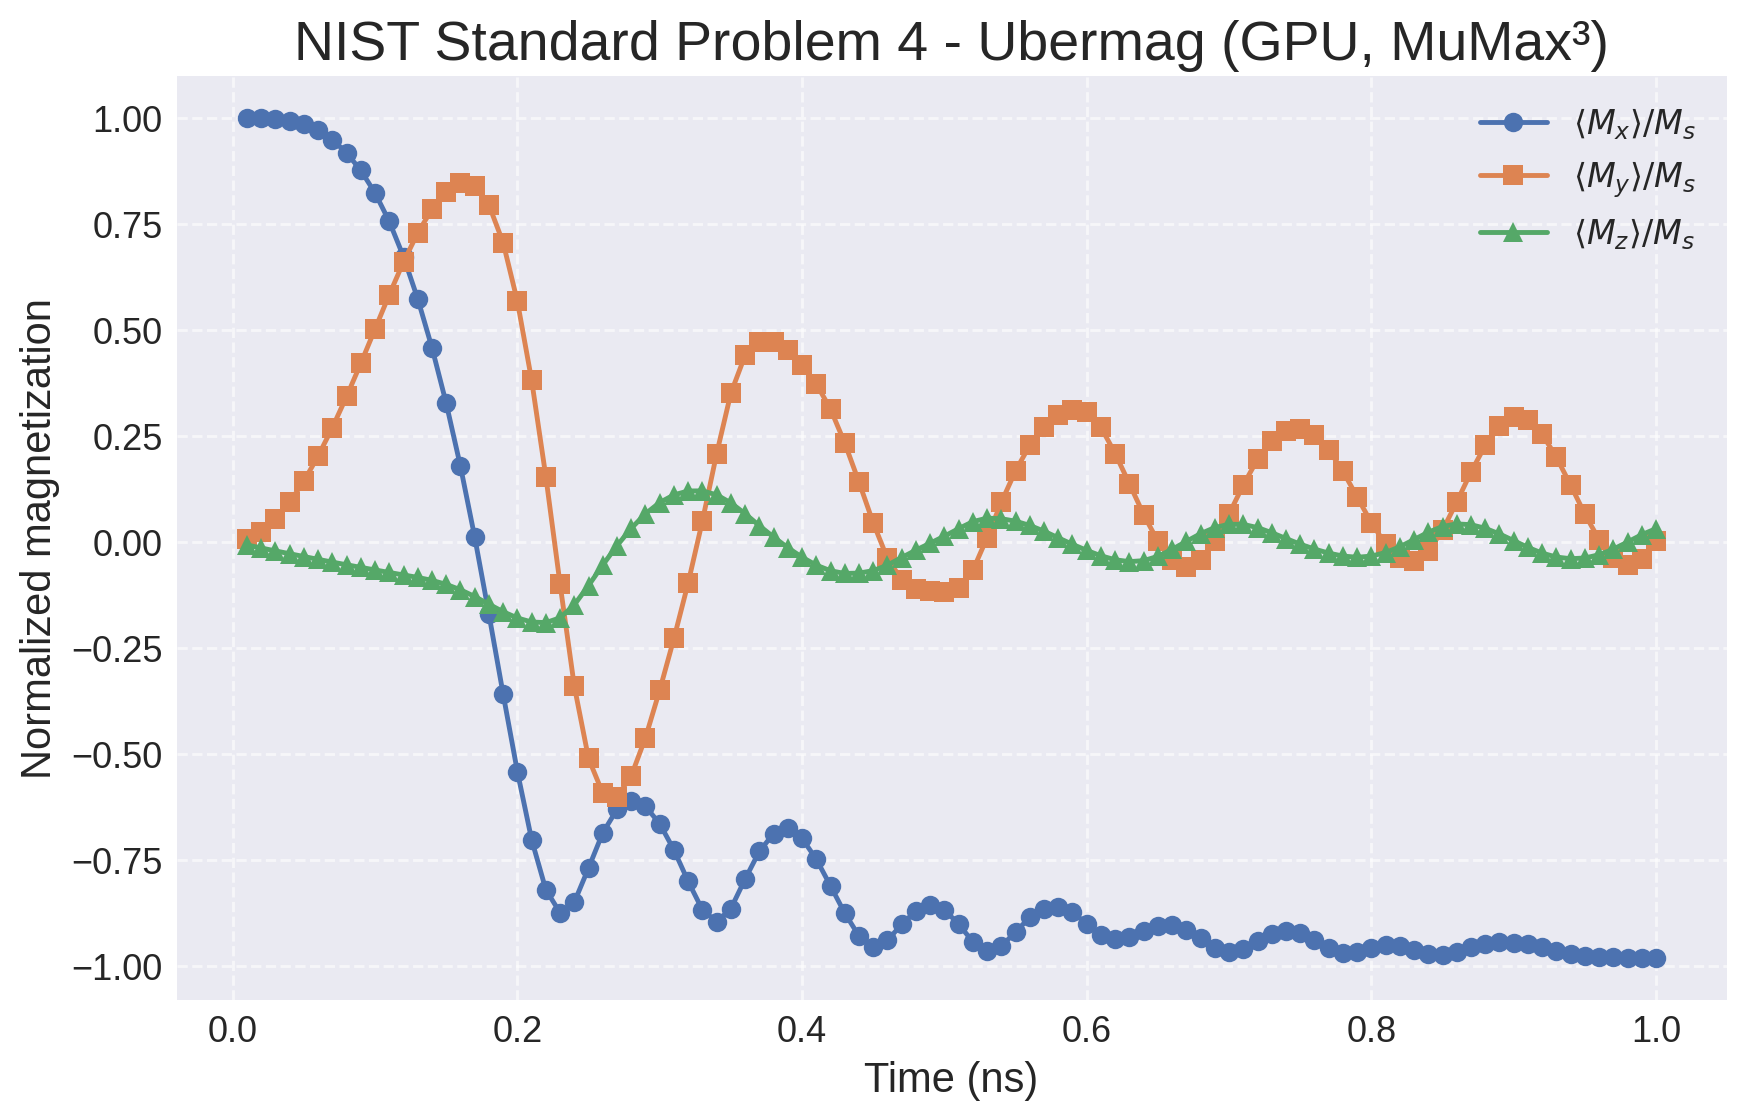

In [16]:
# ------------------- Cell 3 -------------------
#  Imports -------------------------------------------------
import micromagneticmodel as mm          # energy & dynamics DSL
import discretisedfield    as df          # mesh & field handling
import mumax3c             as mx          # GPU‑accelerated driver (MuMax³)
import numpy                as np
import matplotlib.pyplot    as plt
import time                                 # simple timing helper

plt.rcParams['figure.dpi'] = 200

print(f"micromagneticmodel version: {mm.__version__}")
print("-"*50)


#   Geometry, mesh and material -----------------------------
L, W, t = 500e-9, 125e-9, 3e-9                 # film size (m)
cell    = (5e-9, 5e-9, 3e-9)                   # ≤ 5 nm × 5 nm × 3 nm (recommended)

mesh = df.Mesh(p1=(0, 0, 0), p2=(L, W, t), cell=cell)
print(f"Mesh: {mesh}")

# Material parameters (Permalloy‑like)
Ms    = 8.0e5          # A m⁻¹
A     = 1.3e-11        # J m⁻¹
alpha = 0.02           # Gilbert damping
gamma0 = 2.211e5       # m A⁻¹ s⁻¹

# External field B = (‑24.6, 4.3, 0) mT → H = B / µ₀
mu_0 = 4*np.pi*1e-7
Hx   = -24.6e-3 / mu_0
Hy   =  4.3e-3 / mu_0
H_appl = (Hx, Hy, 0.0)                     # (A m⁻¹)

print(f"Applied field (A m⁻¹): {H_appl}")
print("-"*50)


#   Build the micromagnetic system -------------------------
system = mm.System(name="stdprob4")

# Energy: Exchange + Demag + Zeeman
system.energy = (
    mm.Exchange(A=A) +
    mm.Demag() +
    mm.Zeeman(H=H_appl)
)

# Dynamics: Precession + Damping (LLG)
system.dynamics = (
    mm.Precession(gamma0=gamma0) +
    mm.Damping(alpha=alpha)
)

# Initial magnetization – uniform +x, normalised to Ms.
# NOTE: the argument is **nvdim**, not *dim* (API change in 2023)【43†L18-L23】.
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=Ms)

print("System definition finished.")
print("-"*50)


#   (Optional) Relax at zero field first --------------------
# NIST protocol: first relax the sample with H = 0.
# Uncomment the two lines below if you want that step.
# relax = mx.MinDriver()            # GPU‑accelerated energy‑minimiser
# relax.drive(system)                # finds equilibrium at H = 0


#   Time‑drive on the GPU (1 ns, 100 snapshots) ----------
t_sim  = 1e-9      # total simulation time (s)
n_save = 100       # MuMax³ will write 100 data points

driver = mx.TimeDriver()          # GPU‑enabled driver
print("🚀  Starting the GPU time driver …")
tic = time.time()
driver.drive(system, t=t_sim, n=n_save)
print(f" Finished – elapsed {time.time() - tic:.2f} s")
print("-"*50)


#   Post‑processing & plotting ----------------------------
# After the drive finishes a Table object is attached to `system`.
system.table.data['t_ns'] = system.table.data['t'] * 1e9   # ns for the x‑axis

plt.figure(figsize=(10, 6))
plt.plot(system.table.data['t_ns'], system.table.data['mx'],
         'o-', label=r'$\langle M_x\rangle/M_s$')
plt.plot(system.table.data['t_ns'], system.table.data['my'],
         's-', label=r'$\langle M_y\rangle/M_s$')
plt.plot(system.table.data['t_ns'], system.table.data['mz'],
         '^-', label=r'$\langle M_z\rangle/M_s$')
plt.title("NIST Standard Problem 4 - Ubermag (GPU, MuMax³)")
plt.xlabel("Time (ns)")
plt.ylabel("Normalized magnetization")
plt.grid(True, ls='--', alpha=0.6)
plt.legend()
plt.show()